In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image 

In [2]:
data = pd.read_csv('label.csv')

In [3]:
data.head()

,Unnamed: 0,Index,identity,emotion_idx,emotion_cat,type
0,1,1,111,1,Neutral,simple
1,2,2,114,1,Neutral,simple
2,3,3,115,1,Neutral,simple
3,4,4,116,1,Neutral,simple
4,5,5,117,1,Neutral,simple


In [3]:
data['filename'] = [str(i).zfill(4)+'.jpg' for i in data['Index'].tolist()]
data['pointsname'] = [str(i).zfill(4)+'.mat' for i in data['Index'].tolist()]

In [4]:
data = data.drop(columns=['Unnamed: 0'])

In [6]:
data.head()

,Index,identity,emotion_idx,emotion_cat,type,filename,pointsname
0,1,111,1,Neutral,simple,0001.jpg,0001.mat
1,2,114,1,Neutral,simple,0002.jpg,0002.mat
2,3,115,1,Neutral,simple,0003.jpg,0003.mat
3,4,116,1,Neutral,simple,0004.jpg,0004.mat
4,5,117,1,Neutral,simple,0005.jpg,0005.mat


In [22]:
#read points data from mat data 
from scipy.io import loadmat
points_path = 'C:/Users/rui/Desktop/train_set/points/'
n = data.shape[0]
#we've known each matdata include 78 points in 2d and calculate their distance 
points_data = np.zeros([n,3003])
for i in range(n):
    result = loadmat(points_path+data['pointsname'][i])
    key = sorted(result.keys())[-1] 
    points=result[key]
    points_distance=[]
    for d in range(points.shape[0]-1):
        for j in range(d+1,points.shape[0]):
            distance = np.sqrt(np.square(points[d,0]-points[j,0])+np.square(points[d,1]-points[j,1]))
            points_distance.append(distance)
    points_data[i,]=points_distance

In [8]:
#read images 
size = 128
face_X=np.zeros([n,size,size,3])
photo_path = 'C:/Users/rui/Desktop/train_set/images/'
for i in range(n):
    photo = Image.open(photo_path+data['filename'][i])
    photo = photo.resize([size,size])
    face_X[i,] = np.array(photo)/255

In [23]:
#set predictors
from keras.utils import to_categorical
Y = to_categorical(data['emotion_idx'])
Y = Y[:,1:]

Using TensorFlow backend.
C:\Users\rui\Anaconda3\envs\data\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\rui\Anaconda3\envs\data\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\rui\Anaconda3\envs\data\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\rui\Anaconda3\envs\data\lib\site-packages\tenso

<Figure size 432x288 with 0 Axes>

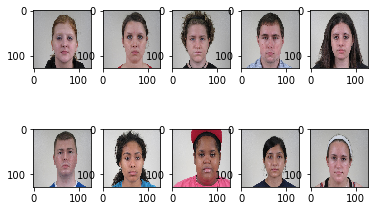

In [10]:
#show images
plt.figure()
fig,ax = plt.subplots(2,5) # set the number of images in each row and column
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(face_X[i,])

In [24]:
from sklearn.model_selection import train_test_split
points_data_0,points_data_1,Y0,Y1 = train_test_split(points_data,Y,test_size=0.2,random_state=123)

In [48]:
# just for fun....
from keras.layers import Dense, Activation, Flatten, Input,Dropout
from keras.layers import BatchNormalization
from keras.models import Model
input_shape = [3003] 
input_layer = Input(input_shape)
x = BatchNormalization()(input_layer) 
x = Dense(16,activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = Dense(96,activation='relu')(x)
x = Dropout(0.5)(x)

output_layer = Dense(22,activation='softmax')(x) 
model = Model(input_layer,output_layer)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3003)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 3003)              12012     
_________________________________________________________________
dense_17 (Dense)             (None, 16)                48064     
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
dense_18 (Dense)             (None, 96)                1632      
_________________________________________________________________
dropout_13 (Dropout)         (None, 96)                0   

In [49]:
from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.01),metrics=['accuracy'])
model.fit(points_data_0, Y0, validation_data = [points_data_1,Y1],epochs=20, batch_size=250)
print('lr=0.01, train complete')
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model.fit(points_data_0, Y0, validation_data = [points_data_1,Y1],epochs=20, batch_size=200)
print('lr=0.001, train complete')
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.0001),metrics=['accuracy'])
model.fit(points_data_0, Y0, validation_data = [points_data_1,Y1],epochs=20, batch_size=200)
print('lr=0.0001, train complete')

Train on 2000 samples, validate on 500 samples
Epoch 1/20
2000/2000 [==============================] - 1s 556us/step - loss: 3.5530 - accuracy: 0.0470 - val_loss: 15.0463 - val_accuracy: 0.0480
Epoch 2/20
2000/2000 [==============================] - 0s 84us/step - loss: 3.1545 - accuracy: 0.0730 - val_loss: 6.0086 - val_accuracy: 0.0800
Epoch 3/20
2000/2000 [==============================] - ETA: 0s - loss: 3.0741 - accuracy: 0.08 - 0s 87us/step - loss: 3.0849 - accuracy: 0.0805 - val_loss: 3.2094 - val_accuracy: 0.0680
Epoch 4/20
2000/2000 [==============================] - 0s 85us/step - loss: 3.0220 - accuracy: 0.0815 - val_loss: 3.0717 - val_accuracy: 0.0440
Epoch 5/20
2000/2000 [==============================] - 0s 85us/step - loss: 2.9572 - accuracy: 0.0875 - val_loss: 2.9651 - val_accuracy: 0.0560
Epoch 6/20
2000/2000 [==============================] - 0s 92us/step - loss: 2.8746 - accuracy: 0.1050 - val_loss: 2.8892 - val_accuracy: 0.0660
Epoch 7/20
2000/2000 [=================

2000/2000 [==============================] - 0s 103us/step - loss: 2.2437 - accuracy: 0.2180 - val_loss: 2.0036 - val_accuracy: 0.2980
Epoch 16/20
2000/2000 [==============================] - 0s 99us/step - loss: 2.2111 - accuracy: 0.2325 - val_loss: 2.0028 - val_accuracy: 0.2960
Epoch 17/20
2000/2000 [==============================] - 0s 97us/step - loss: 2.2193 - accuracy: 0.2370 - val_loss: 2.0018 - val_accuracy: 0.2980
Epoch 18/20
2000/2000 [==============================] - 0s 97us/step - loss: 2.2082 - accuracy: 0.2190 - val_loss: 1.9992 - val_accuracy: 0.2960
Epoch 19/20
2000/2000 [==============================] - 0s 98us/step - loss: 2.2037 - accuracy: 0.2340 - val_loss: 1.9972 - val_accuracy: 0.3000
Epoch 20/20
2000/2000 [==============================] - 0s 98us/step - loss: 2.2260 - accuracy: 0.2235 - val_loss: 1.9962 - val_accuracy: 0.3020
lr=0.0001, train complete
